<a href="https://colab.research.google.com/github/bilalmashooq/ML_Practice/blob/master/experiment1%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Colab 101

In [72]:
a = 2
b = 3
a + b

5

In [73]:
!ls

input  output.7z  sample_data  weights


In [74]:
!nvidia-smi

Wed Nov 20 15:44:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              32W /  70W |   4241MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [75]:
!tpu-info

/bin/bash: line 1: tpu-info: command not found


# Setup
Note: before running any cell, please check that your Runtime has GPU!

## Import modules and setup

In [76]:
#@title Authenticate with Google Acoount and do imports { display-mode: "form" }
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [77]:
#@title Import standard machine learning and data science modules
import numpy as np
import pandas as pd
import random
import os
import shutil
from tqdm import tqdm
from glob import glob
import math
from functools import partial

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# Import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score

# Import zoom function
# from keras_preprocessing.image import random_zoom


from PIL import Image
from IPython.display import display
from matplotlib.image import pil_to_array, imread
from matplotlib import pyplot as plt

np.random.seed(42)
random.seed(42)

tqdm.pandas()

os.environ["KERAS_BACKEND"] = "tensorflow"

In [78]:
#@title Import Keras modules
import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory, array_to_img, img_to_array, load_img
from keras.layers import RandomZoom
from keras import layers
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input, Lambda, AveragePooling2D, Activation, PReLU, ReLU
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, TerminateOnNaN
from keras.optimizers import SGD, Adam
import keras.backend as K

AUTOTUNE = tf.data.AUTOTUNE

In [79]:
keras.__version__

'3.5.0'

In [80]:
#@title Helper functions: image processing and useful plots { display-mode: "form" }
# Google Drive upload/download helpers
def drive_upload_file(full_filename):
  filename = os.path.basename(full_filename)
  file_to_upload = drive.CreateFile({'title': filename})
  file_to_upload.SetContentFile(full_filename)
  file_to_upload.Upload()

def drive_download_file(file_id, local_path='./'):
  # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.FetchMetadata()
  fn = downloaded.metadata.get('originalFilename')
  full_fn = os.path.join(local_path, fn)
  downloaded.GetContentFile(full_fn)
  return full_fn

# Dataset reading helpers
def filter_df(df, min_images_count=0):
  df = df.sort_values('images', ascending=False)
  return df[df.images >= min_images_count]

# Undo ImageNet preprocessing to show images from batch generator
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)  # RGB
de_preproc = lambda x: np.clip((x[..., ::-1]+vgg_mean)/255., 0, 1)

# Visualization helpers
# Images root dir
img_root_dir = 'input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# equal probabilities
equal_apriori = 0.5

# number of thresholds
num_thresholds = 100
# generate a list of  n thresholds between 0.0 and 1.0
thresholds = [i/num_thresholds for i in range(num_thresholds)]

def plot_scores(imposter, genuine):
  """ Plot the scores of the genuine and imposters """

  # Draws a histogram to show score frequencies with values.
  plt.hist(imposter, facecolor='g', alpha=0.50, label='Imposter')
  plt.hist(genuine, facecolor='y', alpha=0.50, label='Genuine')

  # Adding labels and titles to the plot
  plt.xlabel('Score')
  plt.ylabel('Frequency')
  plt.title('Score Distribution')
  plt.grid(True)

  # draw the key/legend
  plot_legends()

  # show the plot
  show_plot()

def calculate_cost(imposter, genuine):
  """ For both users, calculates a confusion matrix and then calculates cost per threshold """

  # generate n number of thresholds

  far = []
  frr = []
  cost = []

  # for each threshold, calculate confusion matrix.
  for t in thresholds:

    FP = 0
    FN = 0
    TP = 0
    TN = 0

    # go through imposters
    for score in imposter:

      if score >= t:
        # imposter passes as a genuine user
        FP += 1
      else:
        # imposter correctly rejected
        TN += 1

    for score in genuine:
      if score >= t:
        # genuine user correctly identified
        TP += 1
      else:
        # genuine user incorrectly rejected
        FN += 1

    far_current = float(FP) / float(len(imposter))
    frr_current = float(FN) / float(len(genuine))

    # calculate our false accept rate(FAR) and add to list
    far.append(far_current)

    # calculate our false reject rate(FRR) and add to list
    frr.append(frr_current)

  return far, frr

def plot_DET_with_EER(far, frr, far_optimum, frr_optimum):
  """ Plots a DET curve with the most suitable operating point based on threshold values"""

  # Plot the DET curve based on the FAR and FRR values
  plt.plot(far, frr, linestyle="--", linewidth=4, label="DET Curve")

  # Plot the optimum point on the DET Curve
  plt.plot(far_optimum,frr_optimum, "ro", label="Suitable Operating Point")

  # Draw the default DET Curve from 1-1
  plt.plot([1.0,0.0], [0.0,1.0],"k--")

  # Draws the key/legend
  plot_legends()

  # Displays plots
  show_plot()

def plot_FAR_vs_FRR(far, frr):
  # Plot FAR and FRR
  plt.plot(thresholds, far, 'g-', label='FAR curve')
  plt.plot(thresholds, frr, 'b-', label='FRR curve')

  # Draws the key/legend
  plot_legends()

  # Displays plots
  show_plot()

def find_EER(far, frr):
  """ Returns the most optimal FAR and FRR values """

  # The lower the equal error rate value,
  # the higher the accuracy of the biometric system.

  # smallest value is most accurate
  far = np.array(far)
  frr = np.array(frr)
  delta = np.abs(far - frr)
  t = np.argmin(delta)
  far_optimum = far[t]
  frr_optimum = frr[t]
  threshold_optimum = thresholds[t]

  return far_optimum, frr_optimum, threshold_optimum

def plot_legends():
  legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
  legend.get_frame().set_facecolor('#ffffff')

def show_plot():
  plt.show()

def extract_template(image_paths, model, target_size=(224, 224), batch_size=32):
  """
  Extract image template from a filename list using a Keras model and tf.data.Dataset.

  Args:
    image_paths: A list of image filenames.
    model: Keras model with a predict method.
    target_size: Tuple (height, width) for resizing images.
    batch_size: Batch size for prediction.

  Returns:
    A list of model prediction results.
  """

  def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    img = zoom_image(img)
    # img = preprocess_input(img)
    return img

  zoom_image = keras.Sequential([
    keras.layers.RandomZoom((-0.5, -0.5)),
    keras.layers.Resizing(target_size[0], target_size[1]),
    keras.layers.Rescaling(scale=1./255)
  ])
  dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  predictions = model.predict(dataset)

  return predictions.tolist()

def name_to_image_path(root_dir, name, image_num):
  return f'{root_dir}/{name}/{name}_{image_num:04d}.jpg'

def evaluate_model(model, pairs_file='./input/lfw-dataset/course-pairsDevTest.csv'):
  # Cut our model at the 'embedding' layer level and convert it to template extractor
  embedding_out = model.get_layer('face_embedding').output
  template_extrator = Model(inputs=[input_layer], outputs=[embedding_out])

  # Read pairs matched and mismatched for dev dataset
  print('Preparing stats from dev set')
  test_pairs = pd.read_csv(pairs_file)
  test_pairs['img_fn1'] = test_pairs.apply(lambda row: name_to_image_path(img_root_dir, row['name1'], row['imagenum1']), axis=1)
  test_pairs['img_fn2'] = test_pairs.apply(lambda row: name_to_image_path(img_root_dir, row['name2'], row['imagenum2']), axis=1)

  # Apply the template model to all images
  test_pairs['template1'] = extract_template(test_pairs['img_fn1'], template_extrator, target_size)
  test_pairs['template2'] = extract_template(test_pairs['img_fn2'], template_extrator, target_size)
  test_pairs['cos_distance'] = test_pairs.apply(lambda row: distance.cosine(row['template1'], row['template2'])/2., axis=1)  # cos distance rescaled to (0,1)

  match_scores = test_pairs[test_pairs.match_pair==1]['cos_distance']
  mismatch_scores = test_pairs[test_pairs.match_pair==0]['cos_distance']

  # Plot model's stats
  genuine = match_scores.values
  imposter = mismatch_scores.values

  far, frr = calculate_cost(imposter, genuine)
  far_optimum, frr_optimum, err_threshold = find_EER(far, frr)

  plot_scores(imposter, genuine)
  plot_DET_with_EER(far, frr, far_optimum, frr_optimum)
  plot_FAR_vs_FRR(far, frr)
  print(f'EER at threshold: {err_threshold}')

  # Now let's calculate accuracy for test set
  test_pairs['pred_match_pair'] = test_pairs['cos_distance'] < err_threshold
  test_pairs['pred_match_pair'] = test_pairs['pred_match_pair'].astype(int)

  print(f'At threshold {err_threshold} accuracy score is {accuracy_score(test_pairs.match_pair.values, test_pairs.pred_match_pair.values):.4f}')

  eer_info = {
          'far_optimum': far_optimum,
          'frr_optimum': frr_optimum,
          'err_threshold': err_threshold,
          'accuracy': accuracy_score(test_pairs.match_pair.values, test_pairs.pred_match_pair.values),
      }
  return test_pairs, eer_info, far, frr


# Dataset preparation

## Download and unpack LFW files

In [81]:
# Prepare Labelled Faces in the Wild dataset
!mkdir -p input/lfw-dataset

# Download LFW file (drive id is '14ra9GYFzdyeubZ5qtSDaDAbFDKPCjdAD')
file_id = '14ra9GYFzdyeubZ5qtSDaDAbFDKPCjdAD'
drive_download_file(file_id, local_path='./input/')

# Unpack zip files
!7z x ./input/lfw-dataset.zip -o./input/lfw-dataset -aoa
!7z x ./input/lfw-dataset/lfw-deepfunneled.zip -o./input/lfw-dataset/lfw-deepfunneled -aoa

# Clean temp files
!rm -r ./input/lfw-dataset/lfw-deepfunneled/__MACOSX/ ./input/lfw-dataset/__MACOSX/



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./input/                  1 file, 116495068 bytes (112 MiB)

Extracting archive: ./input/lfw-dataset.zip
--
Path = ./input/lfw-dataset.zip
Type = zip
Physical Size = 116495068

  0%     13% 25 - lfw-deepfunneled.zip                               29% 25 - lfw-deepfunneled.zip                               46% 25 - lfw-deepfunneled.zip                               60% 25 - lfw-deepfunneled.zip                               61% 25 - lfw-deepfunneled.zip

In [82]:
!ls -lh **/**/**

-rw-r--r--  1 root root 207K Nov 24  2018 input/lfw-dataset/course-pairs.csv
-rw-r--r--  1 root root  35K Nov 24  2018 input/lfw-dataset/course-pairsDevTest.csv
-rwxr-xr-x  1 root root  99K May 17  2018 input/lfw-dataset/lfw_allnames.csv
-rwxr-xr-x  1 root root 121M May 17  2018 input/lfw-dataset/lfw-deepfunneled.zip
-rwxr-xr-x  1 root root 8.0K May 17  2018 input/lfw-dataset/lfw_readme.txt
-rwxr-xr-x  1 root root 9.7K May 17  2018 input/lfw-dataset/matchpairsDevTest.csv
-rwxr-xr-x  1 root root  22K May 17  2018 input/lfw-dataset/matchpairsDevTrain.csv
-rwxr-xr-x  1 root root  17K May 17  2018 input/lfw-dataset/mismatchpairsDevTest.csv
-rwxr-xr-x  1 root root  37K May 17  2018 input/lfw-dataset/mismatchpairsDevTrain.csv
-rwxr-xr-x  1 root root 161K May 17  2018 input/lfw-dataset/pairs.csv
-rwxr-xr-x  1 root root  99K May 17  2018 input/lfw-dataset/people.csv
-rwxr-xr-x  1 root root  30K May 17  2018 input/lfw-dataset/peopleDevTest.csv
-rwxr-xr-x  1 root root  69K May 17  2018 input/lfw

## Copy images into train-validation directories

In [83]:
# Load LFW labels and keep only people with > min_images_count images
df_train = filter_df(pd.read_csv('./input/lfw-dataset/peopleDevTrain.csv'), min_images_count=20)
df_train.head(), len(df_train)

(               name  images
 1328  George_W_Bush     530
 743    Colin_Powell     236
 3842     Tony_Blair     144
 270    Ariel_Sharon      77
 1543    Hugo_Chavez      71,
 46)

In [84]:
# Prepare a list of all images for names in train list
all_train = []
for name in df_train.name.values:
    imgs_for_name = glob(f'./input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/{name}/*.jpg')
    all_train += [{'name': name, 'filename': fn} for fn in imgs_for_name]

# Train-validation split
df_train = pd.DataFrame(all_train)
df_train, df_val = train_test_split(df_train, train_size=0.8, stratify=df_train.name.values)

In [85]:
# Check split lenght
len(df_train), len(df_val)

(1896, 474)

In [86]:
# Create directories structure
root_path = 'input/lfw-train-test-split'

weights_path = './weights'
logs_path = f'{root_path}/logs'
os.makedirs(weights_path, exist_ok=True)
os.makedirs(logs_path, exist_ok=True)

train_path = f'{root_path}/train/'
validation_path = f'{root_path}/validation/'

In [87]:
# Make 'name' directories in the train-valid dirs
shutil.rmtree(train_path, ignore_errors=True)
shutil.rmtree(validation_path, ignore_errors=True)
os.makedirs(train_path, exist_ok=True)
os.makedirs(validation_path, exist_ok=True)

for name in df_train.name.values:
    os.makedirs(os.path.join(train_path, name), exist_ok=True)
    os.makedirs(os.path.join(validation_path, name), exist_ok=True)

print(f"Created directories: \n{train_path}, \n{validation_path}")

Created directories: 
input/lfw-train-test-split/train/, 
input/lfw-train-test-split/validation/


In [88]:
# Copy to train dir
for i, row in tqdm(df_train.iterrows()):
    shutil.copy(row['filename'], os.path.join(train_path, row['name']))

# Copy to validation dir
for i, row in tqdm(df_val.iterrows()):
    shutil.copy(row['filename'], os.path.join(validation_path, row['name']))

1896it [00:00, 4398.89it/s]
474it [00:00, 4462.25it/s]


input/lfw-train-test-split/train/Carlos_Menem/Carlos_Menem_0017.jpg 250 250


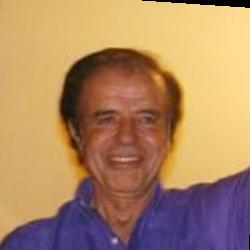

input/lfw-train-test-split/train/Jack_Straw/Jack_Straw_0019.jpg 250 250


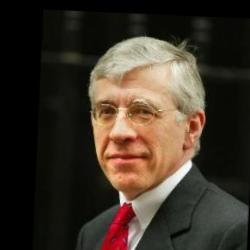

input/lfw-train-test-split/train/George_W_Bush/George_W_Bush_0469.jpg 250 250


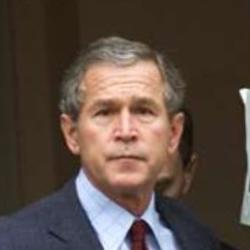

In [89]:
# Show some images
imgs_fn = glob(f'{train_path}/**/*.jpg', recursive=True)
for fn in np.random.choice(imgs_fn, size=3):
    img = Image.open(fn)
    print(fn, img.height, img.width)
    display(img)

# Train models

## Image data generators

In [90]:
!ls {train_path}/*/*.jpg

input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0001.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0002.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0003.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0004.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0005.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0006.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0007.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0008.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0009.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0010.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0011.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0012.jpg
input/lfw-train-test-split/train//Alejandro_Toledo/Alejandro_Toledo_0013.jpg

In [91]:
# Data generators
batch_size = 32*3
target_size = (128, 128)
n_count = 3

In [92]:
train_img_aug = keras.Sequential([
    keras.layers.RandomZoom((-0.45, -0.55)),
    keras.layers.RandomFlip(mode="horizontal"),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.Resizing(target_size[0], target_size[1]),
    keras.layers.Rescaling(scale=1./255)
])

valid_img_aug = keras.Sequential([
    keras.layers.RandomZoom((-0.5, -0.5)),
    keras.layers.Resizing(target_size[0], target_size[1]),
    keras.layers.Rescaling(scale=1./255)
])

In [93]:
def preprocess(image, label, img_aug):
    image = img_aug(image)
    return image, label

In [94]:
# Train data generator
train_dataset =  keras.utils.image_dataset_from_directory(
      train_path,
      labels='inferred',
      label_mode='categorical',
      batch_size=batch_size,
      image_size=(256, 256)
  )

n_classes = len(train_dataset.class_names)
augment_train = partial(preprocess, img_aug=train_img_aug)

# # More real-life version
# train_gen = (train_dataset
#             .cache()
#             .shuffle(100)
#             .map(augment_train, num_parallel_calls=AUTOTUNE)
#             .prefetch(AUTOTUNE)
#             .repeat(n_count)
#             )

# Study-purpose version
train_gen = (train_dataset
            .map(augment_train, num_parallel_calls=AUTOTUNE)
            .repeat(n_count)
            .cache()
            .shuffle(100)
            .prefetch(AUTOTUNE)
            )

# Validation data generator
valid_dataset =  keras.utils.image_dataset_from_directory(
      validation_path,
      labels='inferred',
      label_mode='categorical',
      batch_size=1,
      image_size=(256, 256)
  )
augment_valid = partial(preprocess, img_aug=valid_img_aug)

valid_gen = (valid_dataset
            .map(augment_valid, num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE)
            .cache()
            )

Found 1896 files belonging to 46 classes.
Found 474 files belonging to 46 classes.


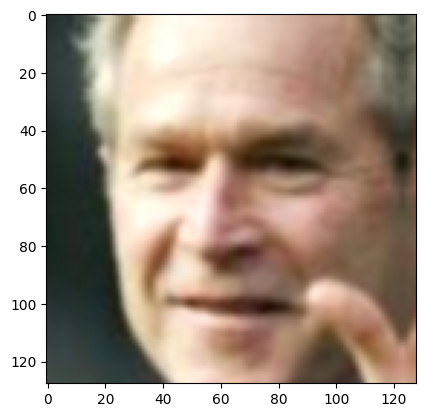

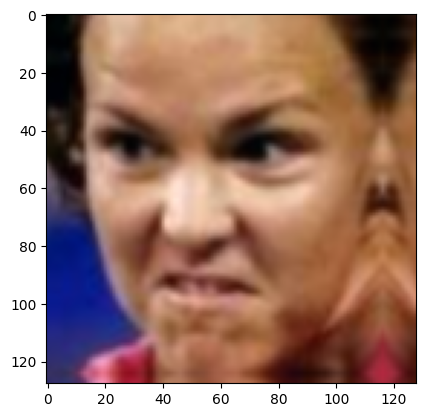

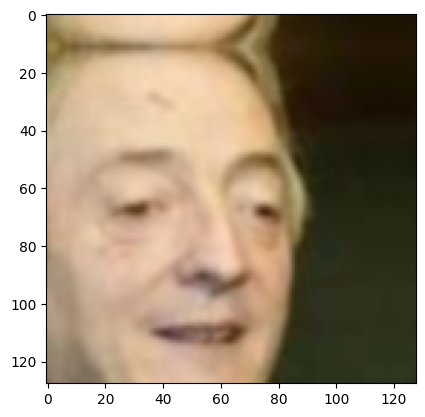

<Figure size 640x480 with 0 Axes>

In [95]:
# Check that train data generator is working
batch_x, batch_y = next(iter(train_gen.take(1)))
for x in batch_x.numpy()[:3]:
    plt.imshow(x); plt.figure()

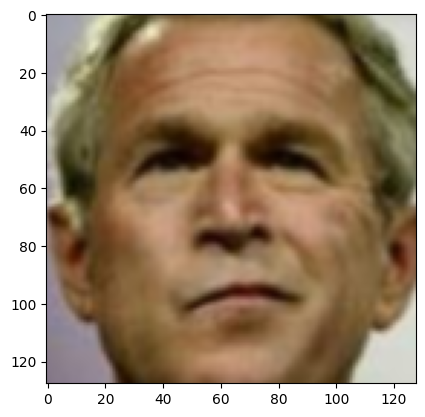

<Figure size 640x480 with 0 Axes>

In [96]:
# Validation generator
batch_x, batch_y = next(iter(valid_gen))
for x in batch_x:
  plt.imshow(x); plt.figure()

## Common training parameters


In [97]:
embedding_size = 32  # Try to change this: 64, 128, 512 ?
dropout_rate = 0.5  # Try to change this: 0.5, 0.9 ?
nb_epochs = 50  # Try to change this: 10, 50, 100 ?

## Linear Regression model

In [98]:
# Set up learning rate
LR = 1e-4
optimizer = Adam(learning_rate=LR)
cce_loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# Linear regression model
input_shape = target_size + (3,)
input_layer = Input(shape=input_shape)
# input_layer = keras.layers.Lambda(preprocess_input)(input_layer)  # preprocess with the ImageNet RGB values
x = Flatten()(input_layer)
output_layer = Dense(n_classes, activation='linear', name='face_embedding')(x)

model = Model(inputs=[input_layer], outputs=[output_layer])

model.compile(optimizer=optimizer, loss=cce_loss, metrics=['accuracy'])
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ face_embedding (Dense)               │ (None, 46)                  │       2,261,038 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,038 (8.63 MB)

 Trainable params: 2,261,038 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Train model and save history
hist_lr = model.fit(
    train_gen,
    epochs=nb_epochs,
    validation_data=valid_gen,
)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.1423 - loss: 6.3448 - val_accuracy: 0.2848 - val_loss: 3.1892
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2898 - loss: 3.0929 - val_accuracy: 0.3755 - val_loss: 2.8190
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3311 - loss: 2.7981 - val_accuracy: 0.4030 - val_loss: 2.7021
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3677 - loss: 2.6076 - val_accuracy: 0.2932 - val_loss: 2.9159
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3702 - loss: 2.5599 - val_accuracy: 0.3903 - val_loss: 2.6438
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4274 - loss: 2.2849 - val_accuracy: 0.4557 - val_loss: 2.5138
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4441 - loss: 2.2408 - val_accuracy: 0.3797 - val_loss: 2.6501
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4467 - loss: 2.2860 - val_accuracy: 0.4093 - 

Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 323ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step


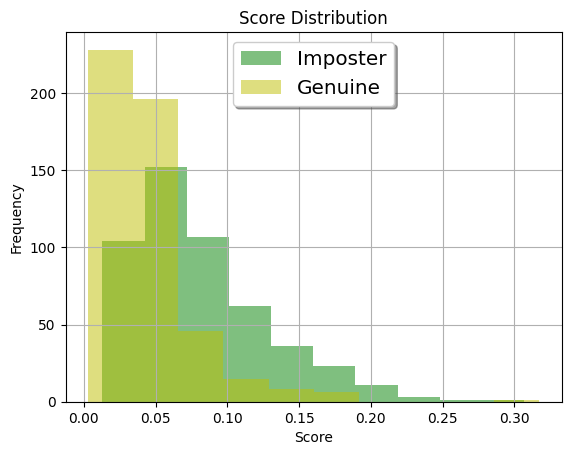

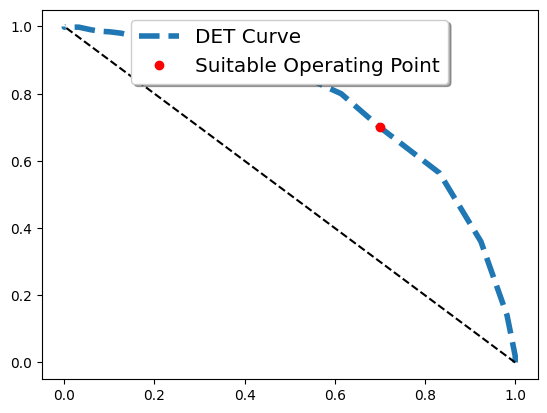

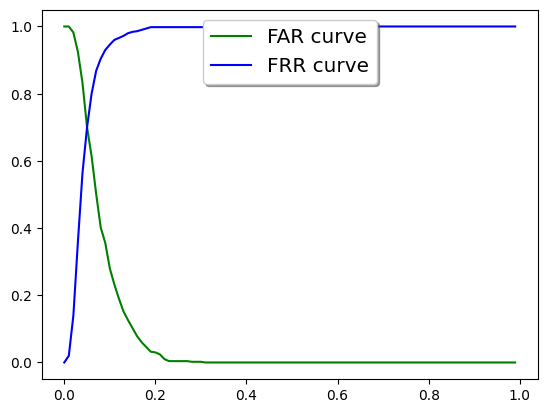

EER at threshold: 0.05
At threshold 0.05 accuracy score is 0.7000


In [102]:
# Evalute model performance with Accuracy, Detection-Error-Tradeoff (DET) curve and  FAR/FRR scores
# Evaluate the model
pairs_df_lr, eer_info_lr, far_lr, frr_lr = evaluate_model(model)


## Train simple Deep Neural Network classifier


In [103]:
# Set up learning rate and automatic LR decreasing
LR = 1e-4
lrate = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1)
optimizer = Adam(learning_rate=LR)
cce_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

# Save best model weights
save_model = ModelCheckpoint(f'{weights_path}/dnn-weight.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

In [104]:
# Create DNN model
input_shape = target_size + (3,)
input_layer = Input(shape=input_shape)

x = input_layer
x = Flatten()(x)
x = Dropout(0.1)(x)

x = Dense(64)(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(64)(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(64)(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(64)(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(embedding_size)(x)
x = ReLU()(x)
x = BatchNormalization(name='face_embedding')(x)
x = Dropout(dropout_rate)(x)

output_layer = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=[input_layer], outputs=[output_layer])

In [105]:
model.compile(optimizer=optimizer, loss=cce_loss, metrics=['accuracy'])
model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │       3,145,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_28 (ReLU)                      │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_29 (ReLU)                      │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_30 (ReLU)                      │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_31 (ReLU)                      │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,163,022 (12.07 MB)

 Trainable params: 3,162,446 (12.06 MB)

 Non-trainable params: 576 (2.25 KB)

In [106]:
# Train the DNN model
hist_dnn = model.fit(
    train_gen,
    epochs=nb_epochs,
    validation_data=valid_gen,
    callbacks=[lrate, save_model],
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.0235 - loss: 4.5699 - val_accuracy: 0.0295 - val_loss: 4.0000 - learning_rate: 1.0000e-04
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0312 - loss: 4.4864 - val_accuracy: 0.0042 - val_loss: 3.8565 - learning_rate: 1.0000e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0270 - loss: 4.4649 - val_accuracy: 0.0148 - val_loss: 3.7444 - learning_rate: 1.0000e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0264 - loss: 4.4355 - val_accuracy: 0.0422 - val_loss: 3.7474 - learning_rate: 1.0000e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.0293 - loss: 4.3739 - val_accuracy: 0.1624 - val_loss: 3.6786 - learning_rate: 1.0000e-04
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0410 - loss: 4.3517 - val_accuracy: 0.0549 - val_loss: 3.7223 - learning_rate: 1.0000e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0308

In [107]:
# Load best weights
model.load_weights(f'{weights_path}/dnn-weight.weights.h5')

Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step


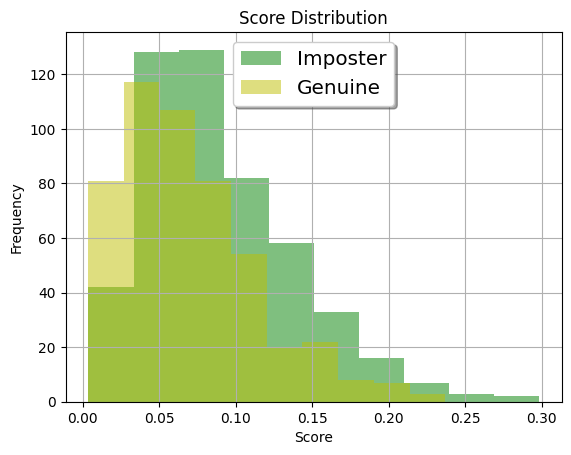

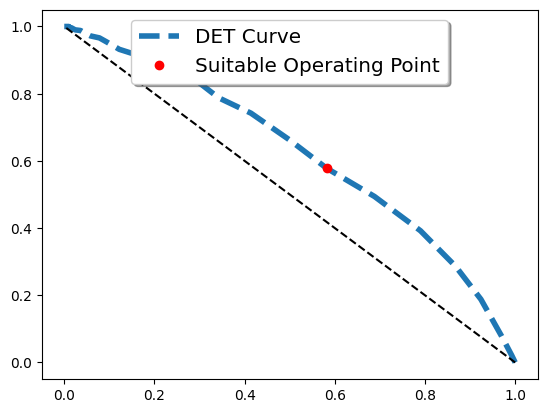

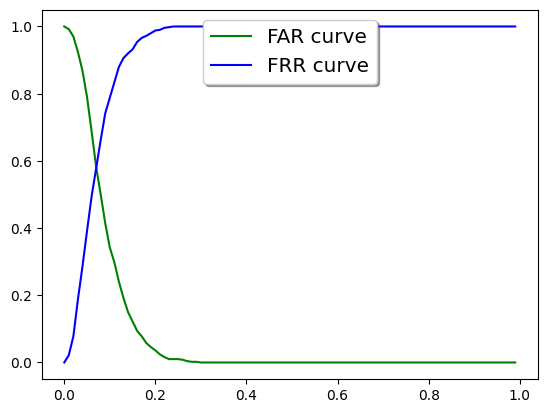

EER at threshold: 0.07
At threshold 0.07 accuracy score is 0.5800


In [108]:
# DNN Model
pairs_df_dnn, eer_info_dnn, far_dnn, frr_dnn = evaluate_model(model)

## Train simple CNN classifier


In [109]:
# Set up learning rate and automatic LR decreasing
LR = 1e-4
lrate = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1)
optimizer = Adam(learning_rate=LR)
cce_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

# Save best model weights
save_model = ModelCheckpoint(f'{weights_path}/custom-cnn-weight.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)

In [110]:
# Create CNN model
input_shape = target_size + (3,)
input_layer = Input(shape=input_shape)

x = input_layer

x = Conv2D(32, (3, 3))(x)
x = ReLU()(x)
x = Conv2D(32, (3, 3))(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = Conv2D(32, (3, 3))(x)
x = ReLU()(x)
x = Conv2D(32, (3, 3))(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = Conv2D(64, (3, 3))(x)
x = ReLU()(x)
x = Conv2D(64, (3, 3))(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = Conv2D(64, (3, 3))(x)
x = ReLU()(x)
x = Conv2D(64, (3, 3))(x)
x = ReLU()(x)
x = AveragePooling2D((2, 2), strides=(2, 2))(x)

x = Flatten()(x)

x = Dense(embedding_size)(x)
x = ReLU()(x)
x = BatchNormalization(name='face_embedding')(x)
x = Dropout(dropout_rate)(x)

output_layer = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=[input_layer], outputs=[output_layer])

In [111]:
model.compile(optimizer=optimizer, loss=cce_loss, metrics=['accuracy'])
model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_33 (ReLU)                      │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_34 (ReLU)                      │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_35 (ReLU)                      │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 58, 58, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_36 (ReLU)                      │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 27, 27, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_37 (ReLU)                      │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_38 (ReLU)                      │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_39 (ReLU)                      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_40 (ReLU)                      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 4, 4, 64)            │               0 │
│ (AveragePooling2D)                   │                             │              

 Total params: 192,366 (751.43 KB)

 Trainable params: 192,302 (751.18 KB)

 Non-trainable params: 64 (256.00 B)

In [112]:
# Train model
hist_cnn = model.fit(train_gen,
                epochs=nb_epochs,
                validation_data=valid_gen,
                callbacks=[lrate, save_model])

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.0177 - loss: 3.8283
Epoch 1: val_loss improved from inf to 3.82173, saving model to ./weights/custom-cnn-weight.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.0178 - loss: 3.8282 - val_accuracy: 0.2236 - val_loss: 3.8217 - learning_rate: 1.0000e-04
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0558 - loss: 3.8002
Epoch 2: val_loss improved from 3.82173 to 3.81506, saving model to ./weights/custom-cnn-weight.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.0560 - loss: 3.8000 - val_accuracy: 0.0633 - val_loss: 3.8151 - learning_rate: 1.0000e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0848 - loss: 3.7395
Epoch 3: val_loss improved from 3.81506 to 3.78092, saving model to ./weights/custom-cnn-weight.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.0851 - loss: 3.7391 - val_accuracy: 0.2257 - val_loss: 3.7809 - learning_rate: 1.

In [113]:
# Load best weights
model.load_weights(f'{weights_path}/custom-cnn-weight.weights.h5')

Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step


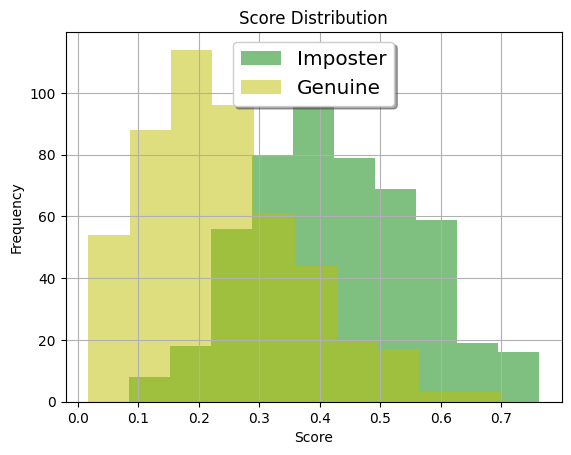

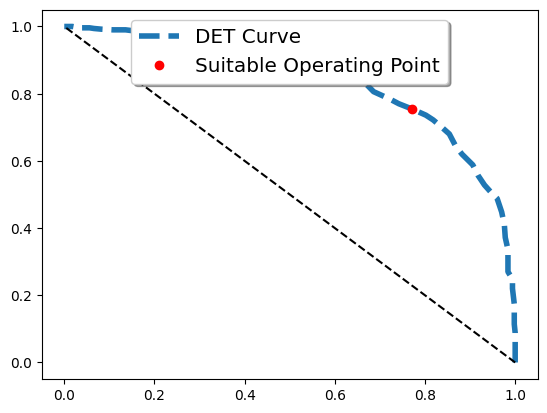

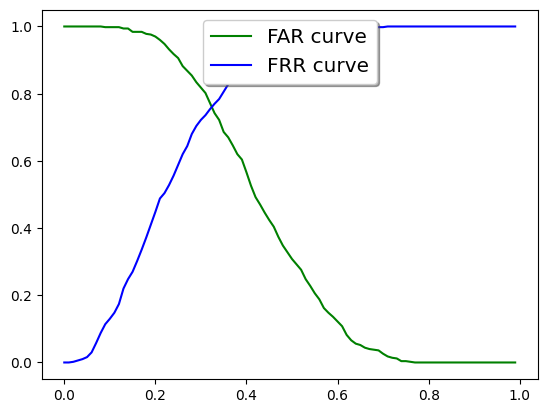

EER at threshold: 0.32
At threshold 0.32 accuracy score is 0.7630


In [114]:
# Evalute model performance with Accuracy, FAR and FRR scores
# CNN Model
pairs_df_cnn, eer_info_cnn, far_cnn, frr_cnn = evaluate_model(model)

# Save outputs as archive

In [115]:
# Last commands
# Save output results to zip
!7z a output.7z .


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Open archive: output.7z
--
Path = output.7z
Type = 7z
Physical Size = 796393265
Headers Size = 180185
Method = LZMA2:24
Solid = +
Blocks = 1

Scanning the drive:
  0M Scan  ./             1156M 20846 Scan  ./input/lfw-dataset/lfw-deepf . lfw-deepfunneled/Ben_Howland/                                                                               5856 folders, 15642 files, 1274568561 bytes (1216 MiB)

Updating archive: output.7z

Items to compress: 21498

  0%      0% 14 U input/lfw-dataset.zip                                 1% 14 U input/lfw-d

In [116]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [117]:
!ls "/gdrive/My Drive/UPEC/Deep Learning Hands-on/Notebooks1"

ls: cannot access '/gdrive/My Drive/UPEC/Deep Learning Hands-on/Notebooks1': No such file or directory


In [118]:
!cp -r weights/ "/gdrive/My Drive/UPEC/Deep Learning Hands-on/Notebooks1"

cp: cannot create directory '/gdrive/My Drive/UPEC/Deep Learning Hands-on/Notebooks1': No such file or directory


In [119]:
!cp -r "/gdrive/My Drive/UPEC/Deep Learning Hands-on/Notebooks1/weights/" .
!ls weights

cp: cannot stat '/gdrive/My Drive/UPEC/Deep Learning Hands-on/Notebooks1/weights/': No such file or directory
custom-cnn-weight.weights.h5  dnn-weight.weights.h5


In [120]:
def plot_training_history(histories, model_names):
    """
    Plots training and validation accuracy and loss for given histories.

    Args:
        histories (list): List of Keras History objects.
        model_names (list): List of model names corresponding to the histories.
    """
    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train Acc')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train Loss')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


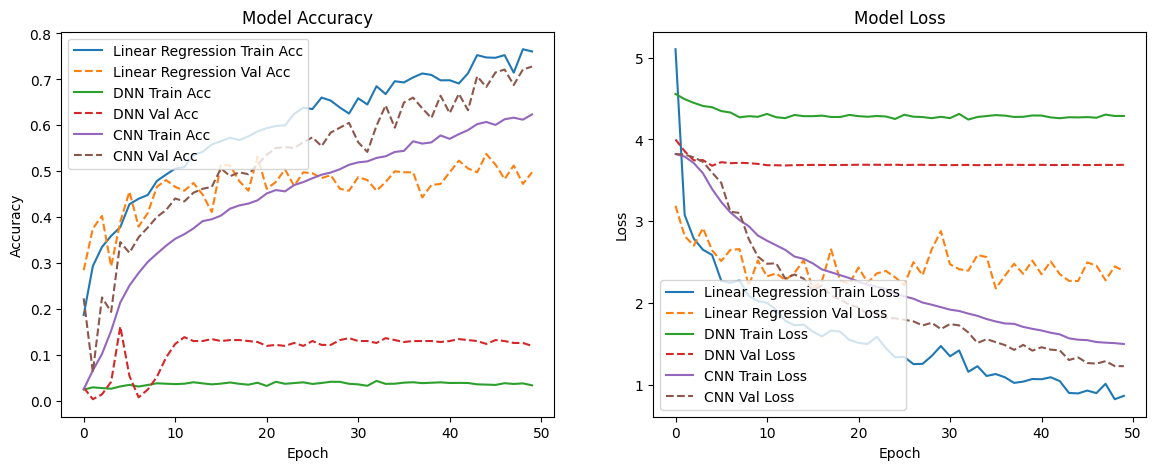

In [121]:
# List of histories and model names
histories = [hist_lr, hist_dnn, hist_cnn]
model_names = ['Linear Regression', 'DNN', 'CNN']

# Plot the training histories
plot_training_history(histories, model_names)


In [122]:
# Collect EER and accuracy data
eer_data = {
    'Model': ['Linear Regression', 'DNN', 'CNN'],
    'EER Threshold': [eer_info_lr['err_threshold'], eer_info_dnn['err_threshold'], eer_info_cnn['err_threshold']],
    'Accuracy at EER': [eer_info_lr['accuracy'], eer_info_dnn['accuracy'], eer_info_cnn['accuracy']],
}
eer_df = pd.DataFrame(eer_data)


In [123]:
def plot_eer_thresholds(eer_df):
    plt.figure(figsize=(10, 5))
    plt.bar(eer_df['Model'], eer_df['EER Threshold'], color=['blue', 'orange', 'green'])
    plt.title('EER Threshold Comparison')
    plt.xlabel('Model')
    plt.ylabel('EER Threshold')
    plt.show()


In [124]:
def plot_accuracy_at_eer(eer_df):
    plt.figure(figsize=(10, 5))
    plt.bar(eer_df['Model'], eer_df['Accuracy at EER'], color=['blue', 'orange', 'green'])
    plt.title('Accuracy at EER Threshold Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy at EER Threshold')
    plt.ylim(0, 1)
    plt.show()


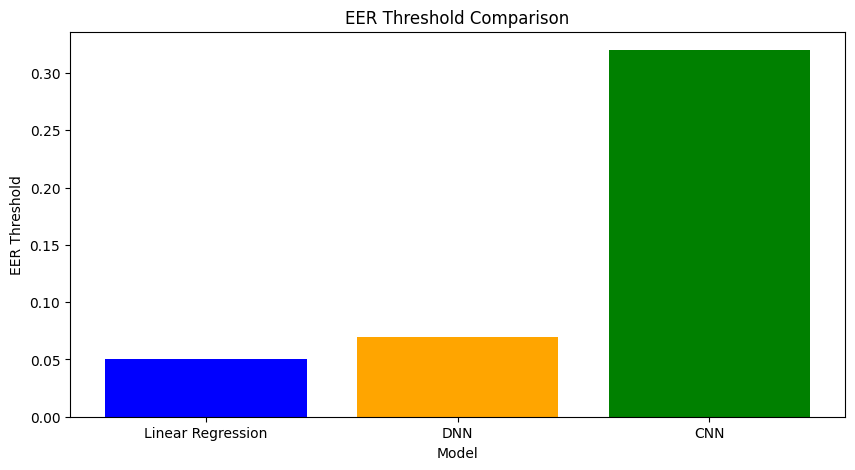

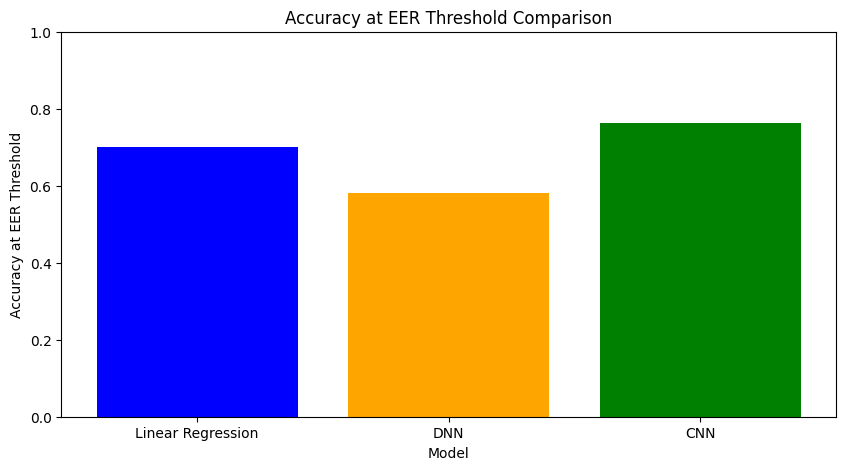

In [125]:
plot_eer_thresholds(eer_df)
plot_accuracy_at_eer(eer_df)


Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step


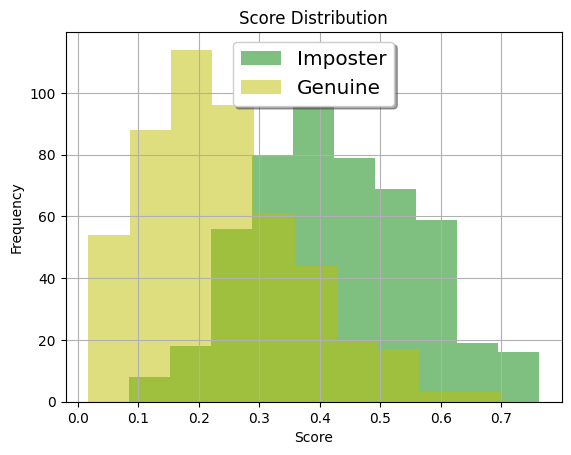

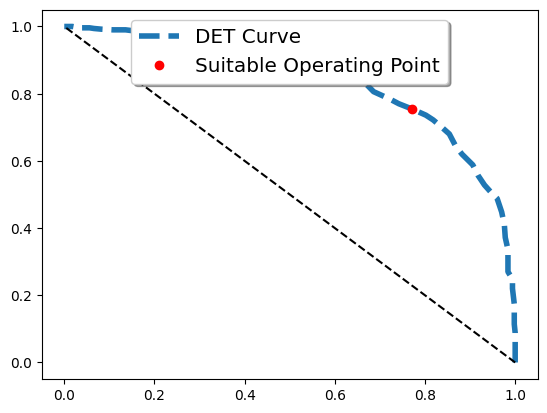

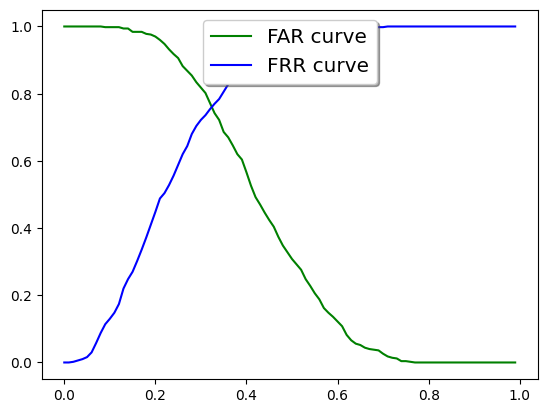

EER at threshold: 0.32
At threshold 0.32 accuracy score is 0.7630
Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step


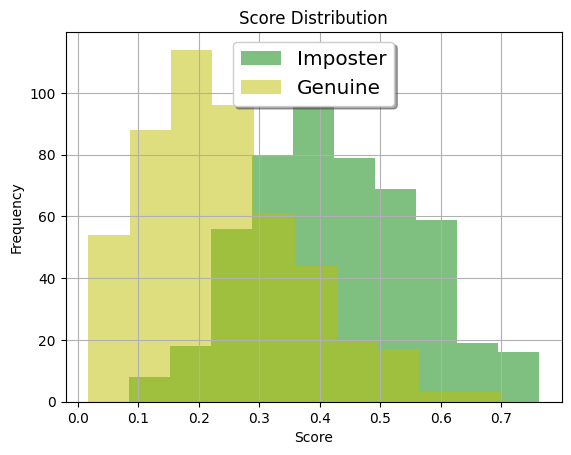

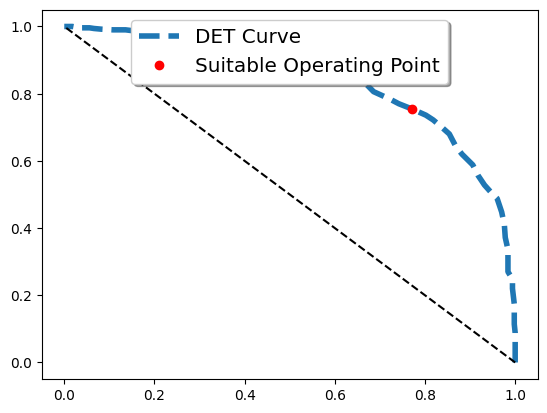

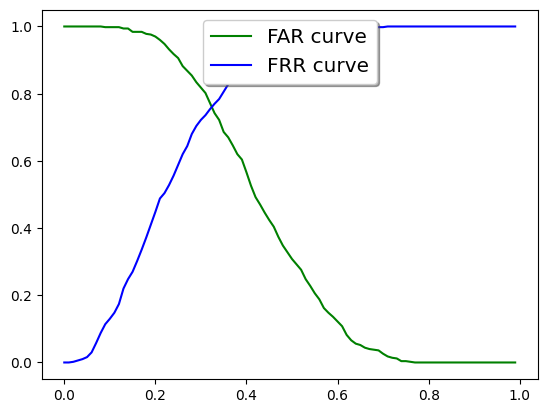

EER at threshold: 0.32
At threshold 0.32 accuracy score is 0.7630
Preparing stats from dev set
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step


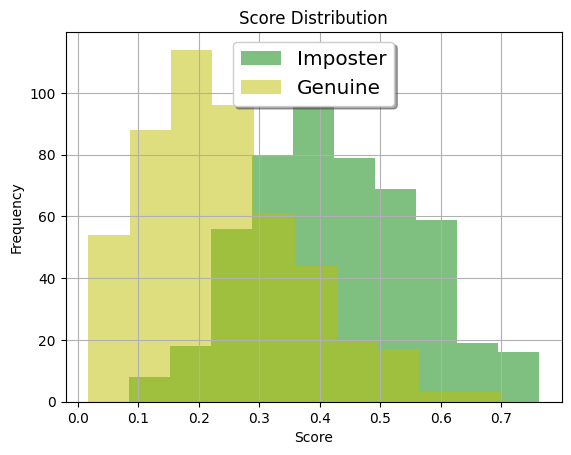

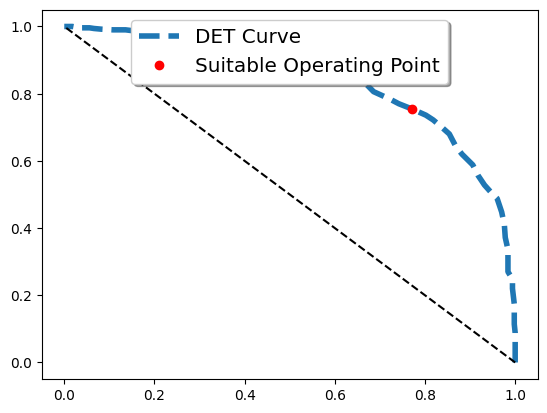

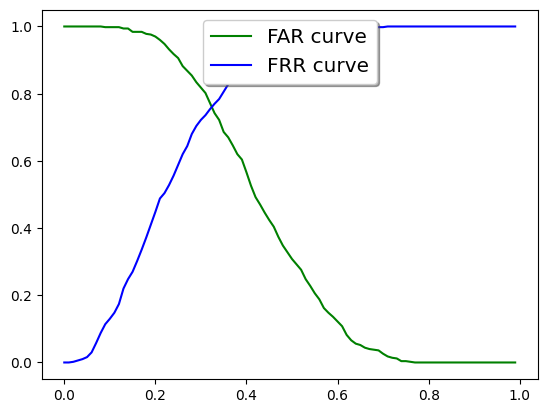

EER at threshold: 0.32
At threshold 0.32 accuracy score is 0.7630


In [126]:
# Linear Regression Model
pairs_df_lr, eer_info_lr, far_lr, frr_lr = evaluate_model(model)

# DNN Model
pairs_df_dnn, eer_info_dnn, far_dnn, frr_dnn = evaluate_model(model)

# CNN Model
pairs_df_cnn, eer_info_cnn, far_cnn, frr_cnn = evaluate_model(model)


In [127]:
def plot_combined_det(far_list, frr_list, model_names):
    plt.figure(figsize=(8, 8))
    for far, frr, name in zip(far_list, frr_list, model_names):
        plt.plot(far, frr, linestyle='--', linewidth=2, label=f'{name} DET Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='EER Line')
    plt.title('Combined DET Curves')
    plt.xlabel('False Accept Rate (FAR)')
    plt.ylabel('False Reject Rate (FRR)')
    plt.legend()
    plt.grid(True)
    plt.show()


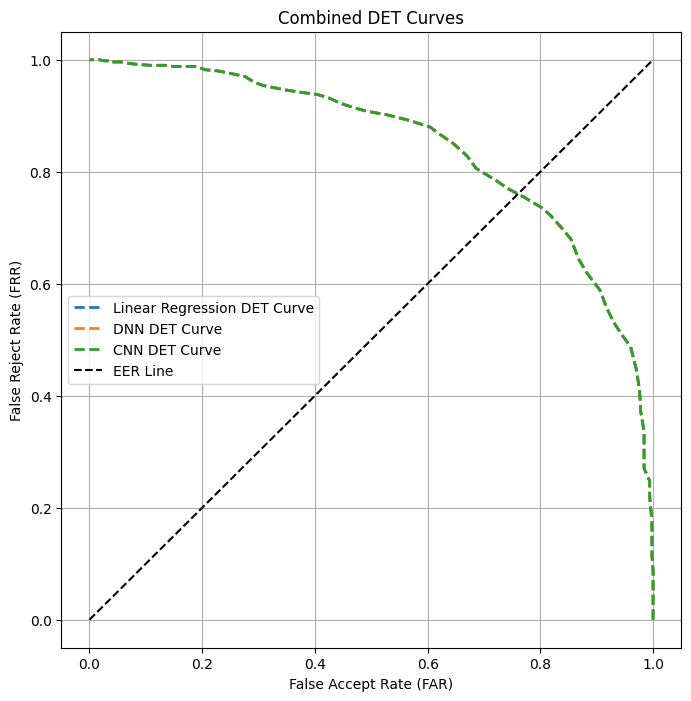

In [128]:
far_list = [far_lr, far_dnn, far_cnn]
frr_list = [frr_lr, frr_dnn, frr_cnn]
model_names = ['Linear Regression', 'DNN', 'CNN']

plot_combined_det(far_list, frr_list, model_names)


In [129]:
def plot_score_distributions(match_scores_list, mismatch_scores_list, model_names):
    for match_scores, mismatch_scores, name in zip(match_scores_list, mismatch_scores_list, model_names):
        plt.figure(figsize=(10, 5))
        plt.hist(mismatch_scores, bins=50, alpha=0.5, label='Imposter')
        plt.hist(match_scores, bins=50, alpha=0.5, label='Genuine')
        plt.title(f'Score Distribution for {name}')
        plt.xlabel('Cosine Distance')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()


In [130]:
# For Linear Regression Model
match_scores_lr = pairs_df_lr[pairs_df_lr.match_pair == 1]['cos_distance'].values
mismatch_scores_lr = pairs_df_lr[pairs_df_lr.match_pair == 0]['cos_distance'].values

# For DNN Model
match_scores_dnn = pairs_df_dnn[pairs_df_dnn.match_pair == 1]['cos_distance'].values
mismatch_scores_dnn = pairs_df_dnn[pairs_df_dnn.match_pair == 0]['cos_distance'].values

# For CNN Model
match_scores_cnn = pairs_df_cnn[pairs_df_cnn.match_pair == 1]['cos_distance'].values
mismatch_scores_cnn = pairs_df_cnn[pairs_df_cnn.match_pair == 0]['cos_distance'].values


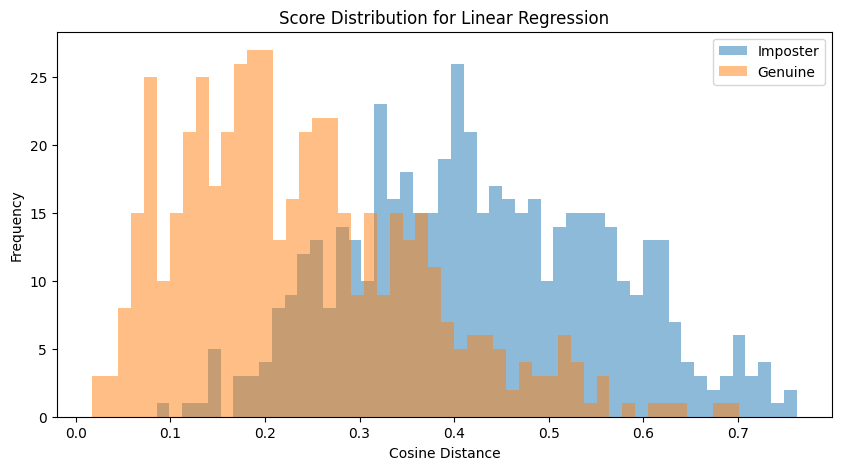

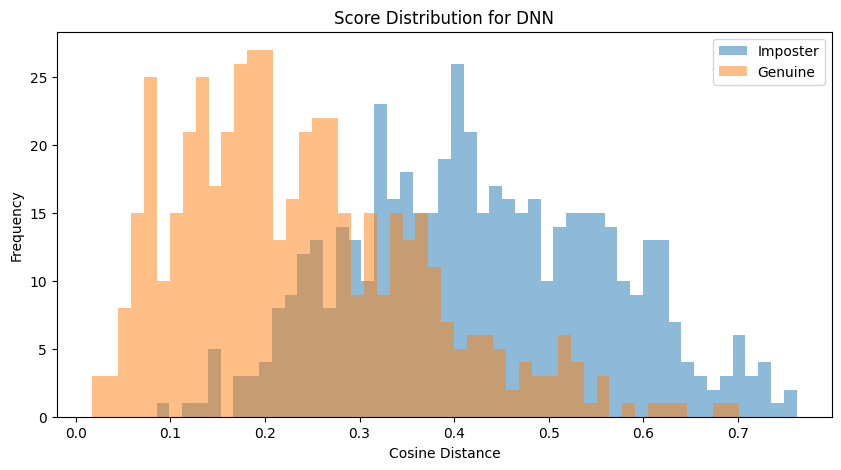

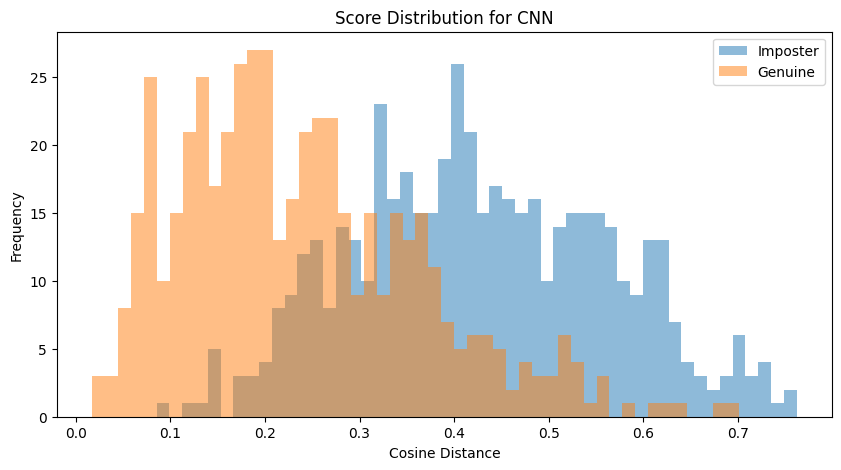